# Experiment Series Master Sheet
## Activation Energy Experiments

## Library Import

In [2]:
from nptdms import TdmsFile
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math
import json
import numpy as np
from scipy.stats import linregress

## Opening JSON Files

Type: <class 'dict'>


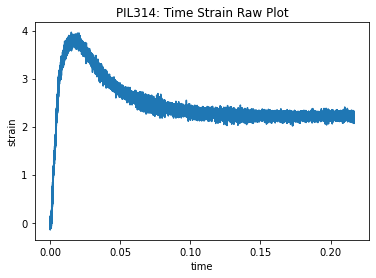

Type: <class 'dict'>


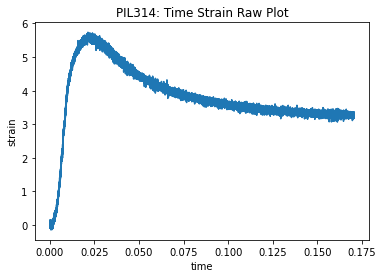

In [3]:
# EMS Data
col_EMS = ['Experiment Number', 'Date', 'Target Temperature', 'Grain Size', 
    'Target Strain Rate', 'Initial Length', 'Final Length', 'Target Pressure', 'Internal Axial Load Read', 'Storage', 'Exp Start', 'Exp Finish']
exp_EMS = pd.read_csv (r'C:\Users\sted9\Mica\AEEM.csv', names = col_EMS, skiprows=1)
experiment_number = pd.Series(exp_EMS['Experiment Number'])

for i in experiment_number:
    with open(f'PIL{i}.json') as json_file:
        data = json.load(json_file)
    
        # Print the type of data variable
        print("Type:", type(data))
    
        # Print the data of dictionary
        stress = data['Stress']
        strain = data['Strain']

        plt.plot(strain, stress)
        plt.xlabel('time')
        plt.ylabel('strain')
        plt.title('PIL{i}: Time Strain Raw Plot')
        plt.show()